In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lab_helper as lh

In [118]:
n_to_lambda = {
    1: 7032,
    2: 6929,
    3: 6717,
    4: 6678,
    5: 6599,
    6: 6533,
    7: 6507,
    8: 6402,
    9: 6383,
    10: 6334,
    11: 6305,
    12: 6267,
    13: 6217,
    14: 6164,
    15: 6143,
    16: 6096,
    17: 6074,
    18: 6030,
    19: 5976,
    20: 5945,
    21: 5882,
    22: 5852,
    23: 5401,
    24: 5341,
    25: 5331,
} # Табличные значение для неона

In [119]:
cal = pd.read_csv("calibration.csv")
cal = cal.sort_values('n').reset_index(drop=True)
cal["lambda"]  = cal["n"].map(n_to_lambda)

print(cal)

     n   deg  lambda
0    1  2970    7032
1    2  2940    6929
2    3  2874    6717
3    4  2862    6678
4    5  2838    6599
5    6  2812    6533
6    7  2806    6507
7    8  2768    6402
8    9  2756    6383
9   10  2742    6334
10  11  2730    6305
11  12  2714    6267
12  13  2694    6217
13  14  2672    6164
14  15  2664    6143
15  16  2644    6096
16  17  2636    6074
17  18  2616    6030
18  19  2590    5976
19  20  2578    5945
20  21  2546    5882
21  22  2528    5852
22  23  2270    5401
23  24  2228    5341
24  25  2222    5331


In [120]:


def plot_calibration_poly(order=2, save_to=None):
    deg_vals = cal["deg"].values
    lam_vals = cal["lambda"].values

    coeffs = np.polyfit(deg_vals, lam_vals, order)

    poly = np.poly1d(coeffs)

    deg_line = np.linspace(deg_vals.min(), deg_vals.max(), 400)
    lam_line = poly(deg_line)

    plt.figure(figsize=(10,8))

    plt.plot(
        deg_line,
        lam_line,
        color="blue",
        label="Аппроксимация"
    )

    plt.plot(
        deg_vals,
        lam_vals,
        "+",
        color="red",
        markersize=8,
        label="Экспериментальные значения"
    )

    plt.grid(visible=True, which='major', axis='both', alpha=1, linewidth=0.9)
    plt.grid(visible=True, which='minor', axis='both', alpha=0.5, linestyle=':')
    plt.minorticks_on()

    plt.title("Градуировка монохроматора")
    plt.xlabel(rf"$\theta, \degree$")
    plt.ylabel(rf"$\lambda, \AA$")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    plt.savefig(save_to)
    plt.show()

    print("Аппроксимация λ через полином степени", order)
    terms = []
    pdeg = order
    for a in coeffs:
        if pdeg > 1:
            terms.append(f"{a:.6g} * deg^{pdeg}")
        elif pdeg == 1:
            terms.append(f"{a:.6g} * deg")
        else:
            terms.append(f"{a:.6g}")
        pdeg -= 1
    poly_str = " + ".join(terms)
    print("λ(nm) ≈", poly_str)
    print("\nКоэффициенты polyfit (от старшей степени к свободному члену):")
    print(coeffs)

    return coeffs


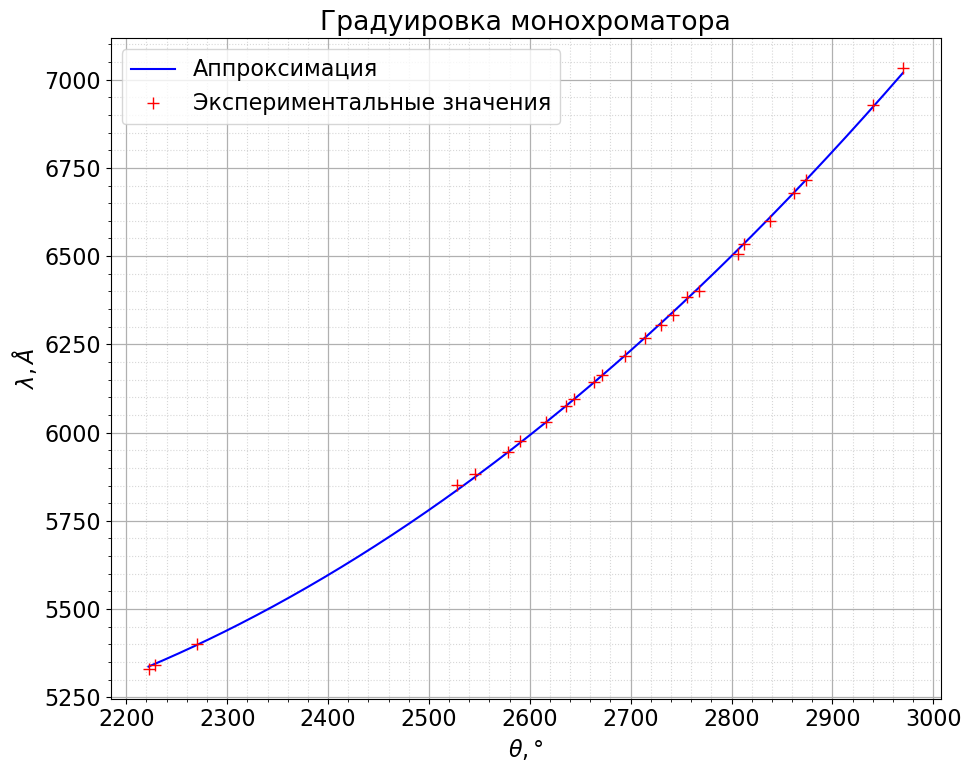

Аппроксимация λ через полином степени 2
λ(nm) ≈ 0.0013907 * deg^2 + -4.97144 * deg + 9517.31

Коэффициенты polyfit (от старшей степени к свободному члену):
[ 1.39069887e-03 -4.97144462e+00  9.51730847e+03]


In [121]:
coefs = plot_calibration_poly(2, "calibration.png")

$\lambda = 5882 \AA$:
        I    U
0   0.161  0.6
1   0.137  0.5
2   0.117  0.4
3   0.093  0.3
4   0.078  0.2
5   0.060  0.1
6   0.043  0.0
7   0.031 -0.1
8   0.019 -0.2
9   0.009 -0.3
10  0.004 -0.4
$\lambda = 7032 \AA$:
        I      U
0   0.600  7.161
1   0.598  6.550
2   0.594  6.000
3   0.590  5.500
4   0.582  5.000
5   0.572  4.500
6   0.554  4.000
7   0.533  3.500
8   0.487  3.000
9   0.430  2.500
10  0.360  2.000
11  0.220  1.500
12  0.099  1.000
13  0.075  0.800
14  0.064  0.700
15  0.053  0.600
16  0.041  0.500
17  0.031  0.400
18  0.022  0.300
19  0.013  0.200
20  0.011  0.165
21  0.004  0.100


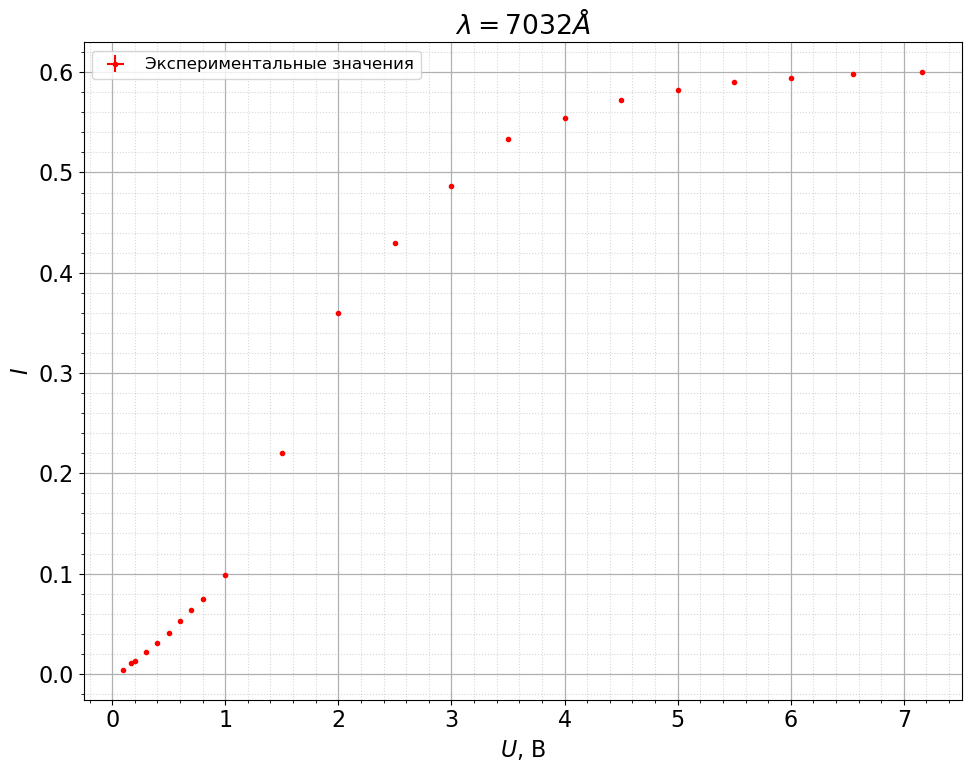

In [122]:
meas = pd.read_csv("measure.csv")


lambdas = [5882, 6030, 6217, 6599, 7032]

def get_block(df, wl, idx):
    """
    wl  – длина волны в ангстремах
    idx – номер пары столбцов: 0 для (5882), 1 для (6030), и т.д.
    вернёт DataFrame с колонками I, U только по этой длине волны
    """
    I_col = str(wl)
    U_col = f"Unnamed: {2*idx+1}"  # 1,3,5,7,9 ...

    block = df[[I_col, U_col]].copy()

    # выбрасываем пустые строки и строки с текстами "I"/"U"
    block = block.dropna()
    block = block[pd.to_numeric(block[I_col], errors='coerce').notnull()]

    # приводим к числам и переименовываем
    block[I_col] = pd.to_numeric(block[I_col])
    block[U_col] = pd.to_numeric(block[U_col])
    block = block.rename(columns={I_col: "I", U_col: "U"}).reset_index(drop=True)

    return block

blocks = {}
for idx, wl in enumerate(lambdas):
    blocks[wl] = get_block(meas, wl, idx)

# например, данные для λ = 5882 Å:
print(r"$\lambda = 5882 \AA$:")
print(blocks[5882])

print(r"$\lambda = 7032 \AA$:")
print(blocks[7032])

lh.plot_data("I_V_7032", rf"$\lambda = 7032 \AA$", rf"$U$, В", rf"$I$", blocks[7032]["U"], blocks[7032]["I"], 0, 0)


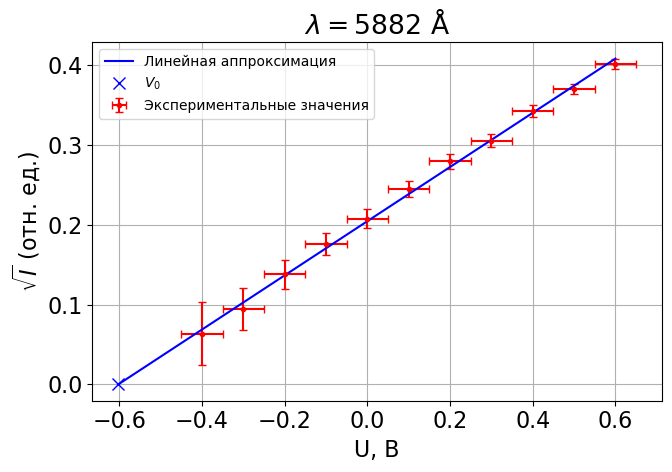

λ = 5882 Å:
  k = 0.3394 ± 0.005415
  b = 0.2044 ± 0.001796
  V0 = -0.6023 В ± 0.01097 В
  |V0| = 0.6023 В



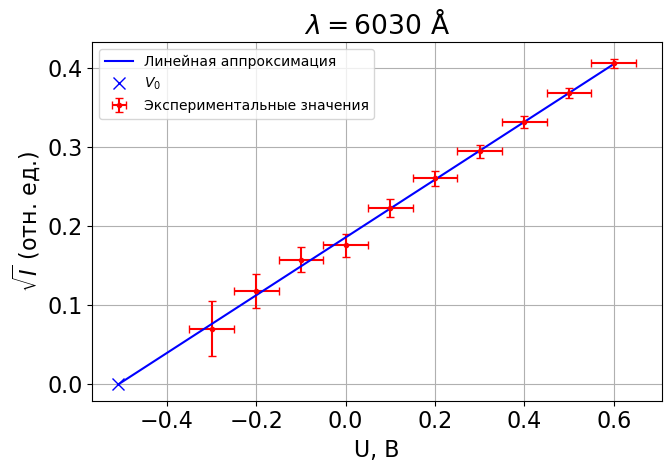

λ = 6030 Å:
  k = 0.3657 ± 0.006033
  b = 0.1861 ± 0.001955
  V0 = -0.5088 В ± 0.009952 В
  |V0| = 0.5088 В



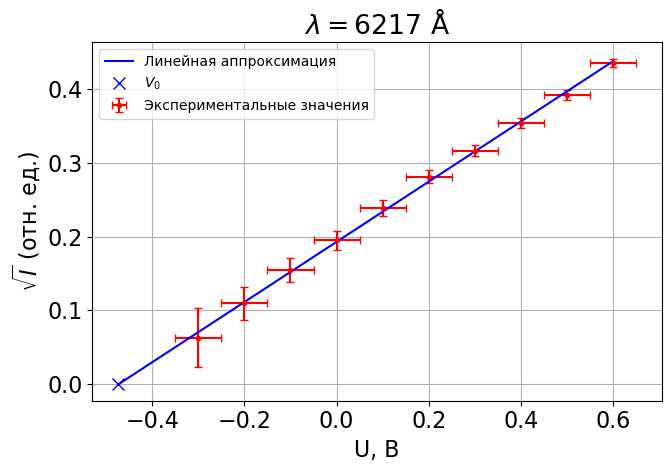

λ = 6217 Å:
  k = 0.4069 ± 0.005277
  b = 0.1928 ± 0.00171
  V0 = -0.4738 В ± 0.007443 В
  |V0| = 0.4738 В



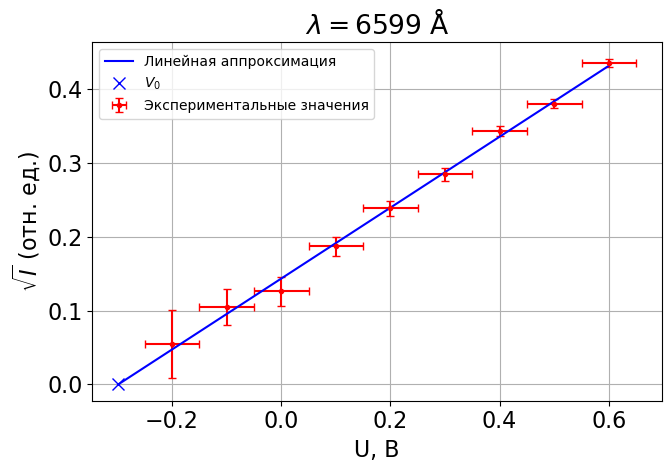

λ = 6599 Å:
  k = 0.4806 ± 0.01143
  b = 0.1435 ± 0.003734
  V0 = -0.2986 В ± 0.01053 В
  |V0| = 0.2986 В



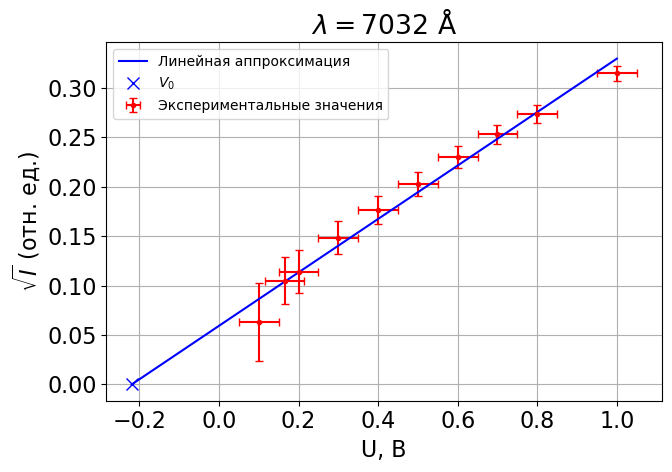

λ = 7032 Å:
  k = 0.2703 ± 0.01289
  b = 0.05925 ± 0.00714
  V0 = -0.2192 В ± 0.02841 В
  |V0| = 0.2192 В



In [123]:
dU_const = 0.05   # В, для U
dI_const = 0.005  # В, для I

def load_block_for_lambda(df, wl, idx):
    """
    Достаёт данные (I,U) для заданной длины волны wl (в ангстремах)
    из общего датафрейма с измерениями.

    idx = порядковый номер пары столбцов:
      wl=5882 -> idx=0,
      wl=6030 -> idx=1,
      wl=6217 -> idx=2,
      wl=6599 -> idx=3,
      wl=7032 -> idx=4.
    """
    I_col = str(wl)
    U_col = f"Unnamed: {2*idx+1}"  # 1,3,5,7,9,...

    block = df[[I_col, U_col]].copy()
    block = block.dropna()
    # убираем строки с текстами "I"/"U", оставляем только числовые
    block = block[pd.to_numeric(block[I_col], errors="coerce").notnull()]

    block = block.rename(columns={I_col: "I", U_col: "U"})
    block["I"] = pd.to_numeric(block["I"])
    block["U"] = pd.to_numeric(block["U"])

    # добавим столбцы с погрешностями приборов
    block["dI"] = dI_const
    block["dU"] = dU_const

    return block.reset_index(drop=True)

def analyze_single_lambda(block, wl_A, cut_tail=False):
    """
    Строит fit sqrt(I) = k*U + b для одной длины волны.
    Возвращает словарь с параметрами и готовыми массивами для графика.

    cut_tail=True для самой длинной волны (7032 Å), где насыщение портит линейность,
    поэтому берём только малые токи около запирания.
    """
    data = block.copy()

    if cut_tail:
        # убьём "толстый" участок насыщения:
        # условно оставим только относительно малые токи и небольшие U
        data = data[data["U"] <= 1].copy()

    U = data["U"].to_numpy(dtype=float)
    I = data["I"].to_numpy(dtype=float)

    # вычисляем sqrt(I)
    sqrtI = np.sqrt(I)

    # ошибки:
    # dU просто константа
    dU = np.full_like(U, dU_const, dtype=float)

    # d(sqrt(I)) = dI / (2 * sqrt(I))
    # чтобы не делить на 0 при очень маленьких I, страхуемся через max(...)
    safe_sqrtI = np.sqrt(np.maximum(I, 1e-12))
    d_sqrtI = dI_const / (2 * safe_sqrtI)

    # линейный фит sqrt(I) = k*U + b (используем твою библиотеку)
    (k, dk), (b, db) = lh.fit_linear(U, sqrtI)

    # запирающее напряжение V0 определяется из sqrt(I)=0 => k*U + b = 0 => U = -b/k
    V0 = -b / k

    # погрешность на V0 через распространение ошибки
    # V0 = -b/k
    # ∂V0/∂k = b / k^2
    # ∂V0/∂b = -1/k
    dV0 = np.sqrt( (b/(k**2))**2 * dk**2 + (1.0/abs(k))**2 * db**2 )

    # построим прямую для красивого графика
    # возьмём диапазон U + точку пересечения (V0), чтобы линия доходила до оси
    U_min = min(U.min(), V0)
    U_max = max(U.max(), V0)
    U_line = np.linspace(U_min, U_max, 200)
    sqrtI_line = k * U_line + b

    return {
        "wl_A": wl_A,
        "U": U,
        "sqrtI": sqrtI,
        "dU": dU,
        "d_sqrtI": d_sqrtI,
        "k": k, "dk": dk,
        "b": b, "db": db,
        "V0": V0,
        "dV0": dV0,
        "U_line": U_line,
        "sqrtI_line": sqrtI_line
    }

def plot_single_lambda(res_dict, savefig=True):
    """
    Рисует один график sqrt(I)(U) с погрешностями (errorbar) + прямую аппроксимации.
    """
    wl_A = res_dict["wl_A"]

    plt.figure(figsize=(7,5), facecolor="white")

    # экспериментальные точки с погрешностями
    plt.errorbar(
        res_dict["U"],
        res_dict["sqrtI"],
        xerr=res_dict["dU"],
        yerr=res_dict["d_sqrtI"],
        fmt=".r",
        capsize=3,
        label="Экспериментальные значения"
    )

    # линейная аппроксимация
    plt.plot(
        res_dict["U_line"],
        res_dict["sqrtI_line"],
        "b",
        label="Линейная аппроксимация"
    )

    # отметим точку пересечения с осью (запирающее напряжение)
    plt.plot(
        [res_dict["V0"]],
        [0],
        "xb",
        markersize=8,
        label=r"$V_0$"
    )

    plt.xlabel("U, В")                 # это напряжение на фотоэлементе
    plt.ylabel(r"$\sqrt{I}$ (отн. ед.)")
    plt.title(rf"$\lambda = {wl_A}\ \mathrm{{\AA}}$")
    plt.grid(True)
    plt.legend(loc="best", fontsize=10)
    plt.tight_layout()

    if savefig:
        plt.savefig(f"sqrtI_vs_U_{wl_A}A.png", dpi=300)

    plt.show()

    # печать чисел для этой длины волны
    print(f"λ = {wl_A} Å:")
    print(f"  k = {res_dict['k']:.4g} ± {res_dict['dk']:.4g}")
    print(f"  b = {res_dict['b']:.4g} ± {res_dict['db']:.4g}")
    print(f"  V0 = {res_dict['V0']:.4g} В ± {res_dict['dV0']:.4g} В")
    print(f"  |V0| = {abs(res_dict['V0']):.4g} В")
    print()

# читаем все измерения разом

all_results = []

for idx, wl in enumerate(lambdas):
    block = pd.DataFrame()
    block = load_block_for_lambda(meas, wl, idx)

    # для самой длинной волны (7032 Å) делаем cut_tail=True,
    # чтобы не портил фит участок насыщения
    need_cut = (wl == 7032)

    res = analyze_single_lambda(block, wl_A=wl, cut_tail=need_cut)
    all_results.append(res)

    # рисуем ОТДЕЛЬНЫЙ график для этой длины волны
    plot_single_lambda(res, savefig=True)


[np.float64(0.6023096392741942), np.float64(0.5087714256987812), np.float64(0.4737521841327311), np.float64(0.29860168778492185), np.float64(0.21917501958851185)]
omega: [3.20239981e+15 3.12380028e+15 3.02984006e+15 2.85445002e+15
 2.67868539e+15]


<>:140: SyntaxWarning: invalid escape sequence '\A'
<>:140: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_70835/642133332.py:140: SyntaxWarning: invalid escape sequence '\A'
  f"{lambda_cut_A:.1f}\\,\text{{\AA}}")


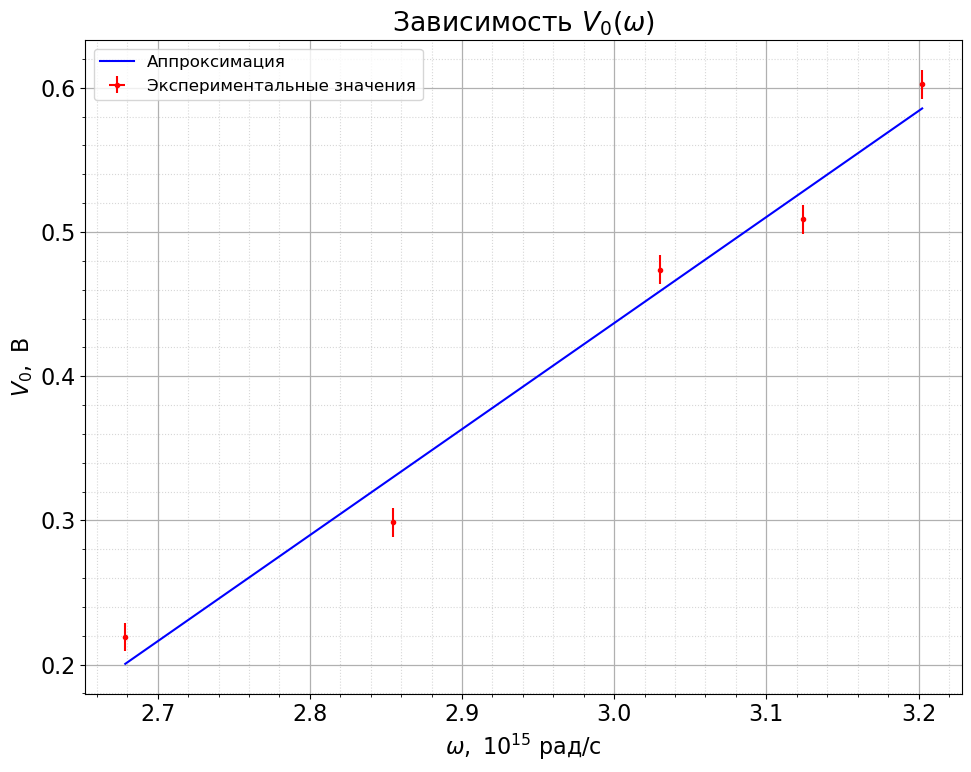

k = dV0/d(ω/10^{15}): $0.74 \pm 0.06$ \,\text{В} / (10^{15}\,\text{рад/с})
b = $-1.8 \pm 0.2$ \,\text{В}

ħ = $1.18 \pm 0.10$\cdot 10^{-34}\,\text{Дж·с}
h = $7.4 \pm 0.6$\cdot 10^{-34}\,\text{Дж·с}\quad(\text{табличное }6.626\cdot10^{-34}\,\text{Дж·с})

W = $1.8 \pm 0.2$ \,\text{эВ}\ (\text{с точностью до контактной разности})
W = $2.8 \pm 0.3$\cdot 10^{-19}\,\text{Дж}

\lambda_{\text{кр}} \approx 782.9\,	ext{нм}\approx 7829.0\,	ext{\AA}


In [124]:

# ----------------------------
# 1. ВВОД ДАННЫХ ЭКСПЕРИМЕНТА
# ----------------------------
# ЗАМЕНИ на свои значения:
# lambda_nm: длины волн, которые ты выставлял на монохроматоре, в нанометрах
# V0_exp: соответствующие им найденные запирающие напряжения V0 (в вольтах),
# полученные через экстраполяцию sqrt(I) -> 0

V0    = [abs(block["V0"]) for block in all_results]

print(V0)

# Проверка длины массивов (должны совпадать)
assert len(lambdas) == len(V0), "Длины массивов lambda_nm и V0_exp не совпадают!"

# ----------------------------
# 2. ПЕРЕВОД В ЧАСТОТУ ω
# ----------------------------
# Формулы:
# lambda (в метрах) = lambda_nm * 1e-9
# ω = 2π c / lambda
# где c ~ 2.99792458e8 м/с

c = 2.99792458e8  # скорость света, м/с
lambda_m = np.array(lambdas, dtype=float) * 1e-10  # анг -> м
omega = 2 * np.pi * c / lambda_m  # рад/с

print(f"omega: {omega}")

dV0 = np.array([
    0.01,
    0.01,
    0.01,
    0.01,
    0.01
], dtype=float)


# ------------------------
# 2. λ → ω (и масштабирование оси)
# ------------------------

# Для красоты по оси X будем откладывать ω в единицах 10^15 рад/с:
omega_scaled = omega / 1e15     # теперь значения порядка ~2–4
dx = np.zeros_like(omega_scaled)
dy = dV0

# ------------------------
# 3. ЛИНЕЙНАЯ АППРОКСИМАЦИЯ + ГРАФИК (через lab_helper)
# ------------------------

# fit_linear_and_plot_data:
# - сам сделает линейное приближение V0(ω_scaled)
# - нарисует точки с ошибками и прямую
# - сохранит график в файл
# - вернёт k = [k, dk], b = [b, db]
k, b = lh.fit_linear_and_plot_data(
    file="V0_omega.png",
    title=r"Зависимость $V_0(\omega)$",
    xlabel=r"$\omega,\ 10^{15}\ \text{рад/с}$",
    ylabel=r"$V_0,\ \text{В}$",
    x=omega_scaled,
    y=V0,
    dx=dx,
    dy=dy
)

k_val, dk_val = k
b_val, db_val = b

# ------------------------
# 4. ФИЗИЧЕСКИЕ ВЕЛИЧИНЫ
# ------------------------

e_charge = 1.602176634e-19  # Кл

# Теория: V0 = (ħ/e) * ω - W/e.
# Мы фитировали по переменной ω_scaled = ω / 1e15:
# V0 = k * ω_scaled + b, где k = (ħ/e) * 1e15,  b = -W/e.
# => ħ = k * e / 1e15

hbar = k_val * e_charge / 1e15
dhbar = dk_val * e_charge / 1e15

h = 2 * np.pi * hbar
dh = 2 * np.pi * dhbar

# Работа выхода: b = -W/e  =>  W = -b * e
W_J = -b_val * e_charge
dW_J = db_val * e_charge

# В электронвольтах (1 эВ = e Дж): W(эВ) = -b
W_eV = -b_val
dW_eV = db_val

# Красная граница (V0 = 0):
# 0 = k * ω_scaled,кр + b  =>  ω_scaled,кр = -b / k
omega_scaled_cut = -b_val / k_val
omega_cut = omega_scaled_cut * 1e15             # рад/с
lambda_cut_m = 2 * np.pi * c / omega_cut
lambda_cut_nm = lambda_cut_m * 1e9
lambda_cut_A = lambda_cut_m * 1e10

# ====== ВЫВОД (аккуратный, для отчёта) ======

print("k = dV0/d(ω/10^{15}):",
      lh.format_latex_value([k_val, dk_val]),
      r"\,\text{В} / (10^{15}\,\text{рад/с})")

print("b =",
      lh.format_latex_value([b_val, db_val]),
      r"\,\text{В}")
print()

# ħ и h в научной записи
print("ħ =",
      lh.format_latex_value([hbar * 1e34, dhbar * 1e34]) +
      r"\cdot 10^{-34}\,\text{Дж·с}")

print("h =",
      lh.format_latex_value([h * 1e34, dh * 1e34]) +
      r"\cdot 10^{-34}\,\text{Дж·с}"
      r"\quad(\text{табличное }6.626\cdot10^{-34}\,\text{Дж·с})")
print()

# Работа выхода
print("W =",
      lh.format_latex_value([W_eV, dW_eV]),
      r"\,\text{эВ}\ (\text{с точностью до контактной разности})")

print("W =",
      lh.format_latex_value([W_J * 1e19, dW_J * 1e19]) +
      r"\cdot 10^{-19}\,\text{Дж}")
print()

# Красная граница
print(r"\lambda_{\text{кр}} \approx "
      f"{lambda_cut_nm:.1f}\\,\text{{нм}}"
      r"\approx "
      f"{lambda_cut_A:.1f}\\,\text{{\AA}}")
